# Real-Time TDDFT
*Roberto Di Remigio*

## Running the simulations

You will, of course, need the appropriate version of ReSpect. The following are sample files for the water molecule using HF and uncontracted cc-pVDZ basis set. Change as needed.

#### SCF step

```
scf:

     geometry:
               O  0.000000  0.000000  0.000000
               H  0.000000  0.000000  0.940000
               H  0.903870  0.000000 -0.258105

     method:         hf
     initmo:         atomic 
     nc-model:       point
     charge:         0
     multiplicity:   1
     maxiterations:  30
     convergence:    1.e-7 

     basis:
            H: ucc-pvdz
            O: ucc-pvdz
```

Assuming the input file is named `scf.inp`, run with:

```bash
respect --scf --inp=scf
```

the `scf.out_scf` output file and `scf.50` checkpoint file will be generated. If the calculation ends successfully, that is.


#### TDSCF step(s)
The TDSCF trajectory will, most likely, be calculated in batches of $n_\mathrm{steps}$ points. The first batch of points will restart from the SCF step, perform $n_\mathrm{steps}$, and save the results to the corresponding `.out_tdscf` output and `.50` checkpoint file.
The template TDSCF step input is:

```
tdscf:
       spectroscopy:    eas
       solver:          magnus
       time-steps:      nsteps x 0.005
       maxiterations:   6 
       convergence:     1.0e-7
       checkpoint:      3
       field:           
             model:     delta
             amplitude: 0.2
             direction: 1.0 0.0 0.0
```

this one is for the perturbation applied in the $x$ direction. We will thus have three templates, one per direction, named `tdscf_x.inp`, `tdscf_y.inp`, and `tdscf_z.inp`, respectively.

Before starting the simulation, we need to substitute `nsteps` with the number of actual steps to be run in the calculation. We'll just look at the $x$ direction, but the gist should be evident. To keep everything in order:

```bash
nsteps_previous=0
nsteps_next=5
cp tdscf_x.inp ${nsteps_next}_tdscf_x.inp
sed -i -e "s/nsteps/${nsteps_next}/g" ${nsteps_next}_tdscf_x.inp
```

The launcher script will look for a similarly named checkpoint file to start the calculation from. Instead of copying the one from SCF (or a previous TDSCF batch of points) we use symlinks:

```bash
if [ "$nsteps_previous" -eq "0" ]; then
  ln -sf scf.50 ${nsteps_next}_tdscf_x.50
else
  ln -sf ${nsteps_previous}_tdscf_x.50 ${nsteps_next}_tdscf_x.50
fi 
```

We are finally ready to roll with:

```bash
if [ "$nsteps_previous" -eq "0" ]; then
  respect --tdscf --inp=${nsteps_next}_tdscf_x 
else
  respect --tdscf --inp=${nsteps_next}_tdscf_x --restart
fi 
```

## Obtain raw data from simulation output

Once we have the output files, we are ready to extract the data from it. The Python code is inspired by the `spectrum.py` script shipped with ReSpect. We are now reading from some reference output files contained in this repository. Change paths accordingly!

**WARNING** This code is written with Python 3 in mind.

In [29]:
# All imports at the top
import pathlib
import numpy as np
import collections
import re
import sys
import scipy.constants
import scipy.signal
from scipy import interpolate
from scipy.interpolate import BSpline
import matplotlib.pyplot as plt
from io import StringIO

In [30]:
def read_data_from_output(fname, what):
    """Read time-dependent signal from output file.

    Parameters
    ----------
    fname: Path
      The output file to read.

    what: str
      What to extract from the output, e.g. "Step EAS" for EAS data.

    Returns
    -------
    A tuple with field strength, size to of the time step, and the data into a NumPy array.
    """
    timestep = 0.0
    field = 0.0
    nsteps = 0
    data = []
    with fname.open() as handle:
        for line in handle:
            if what in line:
                data.append(np.loadtxt(StringIO(line), dtype=float, usecols=(4, 5, 6, 7)))
            elif 'time step length:' in line:
                timestep = float(line.split()[-1])
            elif 'field strength:' in line:
                field = float(line.split()[-1])
            elif 'number of time steps:' in line:
                nsteps = int(line.split()[-1]) 

    signalTD = np.array(data)
    
    return field, timestep, signalTD

The data is read in using an intrinsic NumPy function. The return time is an array of size number of time steps _times_ 4, the number of columns comprising the energy and the $x$, $y$, and $z$ components of the detected signal.

In [45]:
def check_equal(iterator):
    """Checks that the contents of iterator are all equal.
    """
    iterator = iter(iterator)
    try:
        first = next(iterator)
    except StopIteration:
        return True
    return all(first == rest for rest in iterator)

def reader(data_dir, root_name):
    """Read data from output files.
    
    Parameters
    ----------
    data_dir: Path
        Path to the directory with the output files.
    
    root_name: str
        Common root of the output filenames.

    Returns
    -------
    The filename of a NumPy compressed array. This is saved to the current working directory
    and contains the data extracted from the plain-text files.
    
    Notes
    -----
    It is assumed that simulations in the three Cartesian directions have been performed
    and the output is saved to filenames `root_name`_{x,y,z}.out_tdscf
    """
    # Get out_tdscf files, sorted by direction (x, y, z)
    out_tdscf = sorted(data_dir.glob('{}*.out_tdscf'.format(root_name)))
    
    raw_signal = {}
    field = 0.0
    timestep = 0.0
    what = 'Step EAS' # What to extract
    for _, v in enumerate(out_tdscf):
        # Get filename, split on underscore, get the last element in the list
        # FIXME this is not a general way to extract this information
        # FIXME (probably?) the field is assumed to always have the same strength!
        direction = v.stem.replace(root_name + '_', '')
        field, timestep, data = read_data_from_output(v, what)
        raw_signal.update({direction : data})
            
    # Check that sizes of raw data are matching, abort if not
    error_message = ''
    if not check_equal((v.shape for v in raw_signal.values())):
       error_message += '  Shapes of TD signals in different directions DO NOT MATCH\n'
       for k, v in raw_signal.items():
           error_message += '  {0} direction has shape {1}'.format(k, v.shape)
           error_message += '\n        ( check whether the input file is formatted correctly )'
       print(error_message)
       sys.exit(-1)

    # Save to compressed NumPy array the raw data
    npz_name = '{}-raw_TD-data.npz'.format(root_name)
    np.savez(npz_name, field=field, 
                       timestep=timestep,
                       nsteps=raw_signal['x'].shape[0],
                       xdata=raw_signal['x'], 
                       ydata=raw_signal['y'], 
                       zdata=raw_signal['z'])
    print('Raw data saved to {}'.format(npz_name))
    
    return npz_name

We are now ready to run the analysis. At each time step $t_{i}$ we have an induced signal matrix $G^{(i)}_{uv}$ with $u, v \in {x, y, z}$. We will save the whole thing, even though to get the spectrum only the trace of the induced signal is needed: $G^{(i)} = \frac{1}{3}\mathrm{tr} \mathbf{G}^{(i)}$. This approach is possibly a bit wasteful of memory, but it could make it easier to extend to the extraction of higher order properties.

In [32]:
# Extract the diagonal components of the induced signal, i.e. t-direction signal from t-direction perturbation
# At each time step we have a signal matrix G_{ij}(\omega), 
# so our data structure will be a list (which gives the step-indexing) of matrices.
# We define a custom data structure by means of a namedtuple
class Signal(collections.namedtuple('Signal', 'nsteps timestep field signal')):
    __slots__ = ()

    
    def __new__(cls, raw_data):
        nsteps, timestep, signal = cls._signal_from_raw_data(raw_data)
        field_strength = raw_data.f.field
        return super(cls, Signal).__new__(cls, nsteps, timestep, field_strength, signal)
    
    
    def _signal_from_raw_data(raw):
        """Read raw data into more amenable data structures
    
        Parameters
        ----------
        raw: dict
          Raw signal.
    
        Returns
        -------
        A tuple of data from the analysed trajectory.
        """    
        # Extract timestep
        timestep = raw.f.timestep
    
        # Extract number of steps
        nsteps = raw.f.nsteps
     
        # Stacking TD signals for the various direction into a 3-Dimensional array
        # The first dimension is the time step,
        # the second dimension is the direction of the perturbing field (x: 0, y: 1, z: 2), 
        # the third dimension is the detection direction for the induced signal (x: 0, y: 1, z: 2)
        # Hence: signal_timestep_view[n] is the full 3x3 induced signal at time step n.
        # NOTE: We are discarding the energy.
        signal_timestep_view = np.stack((raw.f.xdata[:, 1:], raw.f.ydata[:, 1:], raw.f.zdata[:, 1:]), axis=1)
      
        return nsteps, timestep, signal_timestep_view
    
    
    def compute_spectrum(cls, prefactor, field_time=0.0, damping=None, scaling=1.0):
        """Compute the spectrum from the time-dependent signal using the Fast Fourier Transform.
        
        Parameters
        ----------
        prefactor: function
            Prefactor for the spectroscopy, e.g. :math:`\frac{4\pi\omega}{3c}` for EAS.
        
        field_time: float, optional
            Center of perturbing field.
        
        damping: float, optional
            Damping factor for the computed signal.
            
        scaling: float, optional
            Scaling factor for the spectrum.
        
        Returns
        -------
        A tuple with the spectrum and poles. 
        The `spectrum` is a tuple of NumPy arrays: (frequency, intensity).
        The `poles` is a tuple of NumPy arrays: (frequency at pole, intensity at pole)
        
        Notes
        -----
        https://docs.scipy.org/doc/numpy/reference/routines.fft.html
        """
        # Compute isotropic average of the signal
        signal_iso = np.array([np.trace(v)/3.0 for v in cls.signal])
        signal_iso /= cls.field
       
        # Generate array of time steps
        time = np.array([i*cls.timestep for i in range(cls.nsteps)])
        
        # Set damping factor
        if damping is None:
            damping = -np.log(0.005) / time[-1]
        
        # Report settings
        cls._report(time[-1], damping, field_time)
        
        # Damp isotropic average of signal
        signal_iso *= np.exp(-damping * time)
        
        # Real discrete Fourier transform
        # signal_iso is now the signal in the frequency domain
        signal_iso = np.fft.rfft(signal_iso)
        
        # Get the frequencies, only the positive part is relevant
        freq = np.fft.rfftfreq(time.size)
        # for an even number of points, make the last frequency positive
        freq[-1] = abs(freq[-1])
        freq *= 2 * np.pi / cls.timestep
        
        # Correct the phase to get the factor d_k in \sum_k d_k \exp(-iw_k t) from real-FFT
        signal_iso *= - np.exp(1j * field_time * freq)
        # Normalize
        signal_iso *= cls.timestep

        # Detect poles by looking at the maxima of the imaginary (absorptive) part of the signal
        pole_idx = sorted(scipy.signal.argrelmax(np.imag(signal_iso))[0])
        
        # The frequency-dependent polarizability (FDP) as a tuple of NumPy arrays.
        # alpha[0] is the array of frequencies (a.u.)
        # alpha[1] is the complex FDP (a.u.)
        alpha = (freq, signal_iso)
        
        # The poles of the FDP as a tuple of NumPy arrays.
        # alpha_poles[0] is the array of poles (a.u.)
        # alpha_poles[1] is the complex FDP at the poles, scaled by the damping factor (a.u.)
        alpha_poles = (freq[pole_idx], signal_iso[pole_idx] * damping)
         
        # Get the spectrum, i.e. apply spectroscopy-specific prefactor and scaling to the FDP
        factor = np.array([prefactor(omega) for omega in alpha[0]])
        intensity = np.multiply(alpha[1].real, factor.real) + 1j * np.multiply(alpha[1].imag, factor.imag)
        spectrum = (alpha[0], intensity * scaling)
            
        # Get the poles, i.e. apply spectroscopy-specific prefactor and scaling to the poles of the FDP
        poles = (spectrum[0][pole_idx], spectrum[1][pole_idx] * damping)
            
        return spectrum, poles
        
        
    def _report(cls, final_time, damping, field_time):
        """Print report on spectrum calculation.
        """
        report = '''
    RT-TDDFT Analysis --- Computing EAS
    Number of steps = {nsteps:4d}
    Time step = {timestep:.3E} a.u.
    Field strength = {field:.3E} a.u.
    Field centered at time = {fieldtime:.3E} a.u.
    Damping = {damping:.3E} a.u.
    Resolution = {resEh:14.8f} E_h ({reseV:14.8f} eV)
    Hartree energy = {hartree2eV:20.8f} eV
    Speed of light = {c:20.8f} a.u.
        '''
        # Resolution in E_h
        resEh = 2 * np.pi / (final_time - field_time)
        reseV = resEh * scipy.constants.value('Hartree energy in eV')
        
        print(report.format(nsteps=cls.nsteps,
                hartree2eV=scipy.constants.value('Hartree energy in eV'),
                c=scipy.constants.value('inverse fine-structure constant'),
                timestep=cls.timestep, field=cls.field, fieldtime=field_time,
                damping=damping, resEh=resEh, reseV=reseV))

        
def eas_prefactor(omega):
    """
    Prefactor for EAS spectroscopy.
    
    Parameters
    ----------
    omega: float
        Frequency
    
    Returns
    -------
    The prefactor for EAS spectroscopy as a complex number.
    
    .. math::
       f(\omega) = 1 + \mathrm{i}\frac{4\pi\omega}{3c}
       
    Notes
    -----
    Why a complex number? Because the EAS spectrum is the imaginary (absorptive) part 
    of the frequency-dependent polarizability and the scaling need only be applied 
    to that part.
    """
    c = scipy.constants.value('inverse fine-structure constant')
    return np.complex(1.0, (4.0 * np.pi * omega) / (c))

Since the spectrum is only known at a discrete set of point, we will have to interpolate to get a smooth curve. We use B-spline interpolation as implemented in `scipy`.

In [49]:
def cubic_spline_smoothing(x, y, s):
    """Smoothing cubic spline.
    
    Parameters
    ----------
    x: array_like
        Array of x values
    
    y: array_like
        Array of corresponding y values
        
    s: float
        Spline smoothing parameter
    
    Returns
    -------
    A tuple with the x values in the interval and the y values computed from the smoothing spline
    """
    t, c, k = interpolate.splrep(x, y, s=s, k=3)
    spline = BSpline(t, c, k, extrapolate=False)
    x_smooth = np.linspace(x.min(), x.max(), 3 * x.shape[0])
    return (x_smooth, spline(x_smooth))


def filter_spectrum_data(data, threshold):
    """
    Filter the spectrum tuple based on its first dimension.
    """
    indexing = np.where(data[0] <= threshold)
    return (data[0][indexing], data[1][indexing])

Where is the data? /home/roberto/Workspace/robertodr/real-time/ref

Read data from /home/roberto/Workspace/robertodr/real-time/ref/20_tdscf_x.out_tdscf
Read data from /home/roberto/Workspace/robertodr/real-time/ref/20_tdscf_y.out_tdscf
Read data from /home/roberto/Workspace/robertodr/real-time/ref/20_tdscf_z.out_tdscf
Raw data saved to 20_tdscf-raw_TD-data.npz

    RT-TDDFT Analysis --- Computing EAS
    Number of steps =   21
    Time step = 5.000E-03 a.u.
    Field strength = 2.000E-01 a.u.
    Field centered at time = 0.000E+00 a.u.
    Damping = 5.298E+01 a.u.
    Resolution =    62.83185307 E_h ( 1709.74180829 eV)
    Hartree energy =          27.21138602 eV
    Speed of light =         137.03599914 a.u.
        


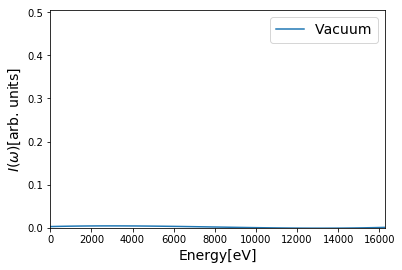

In [36]:
# Where is the data? We use pathlib to manipulate paths (directories and files)
data_dir = pathlib.Path('ref').resolve()
print('Where is the data? {}\n'.format(data_dir))

root_name = '20_tdscf'
npz_file_name = reader(data_dir, root_name)
raw_signal = np.load(npz_file_name)
signal = Signal(raw_signal)
spectrum, poles = signal.compute_spectrum(eas_prefactor)

# We are now ready to plot the spectrum. 
# The energy scale of the spectrum data structure is in Hartree, but we can easily convert it to electronvolt.
Hartree2eV = scipy.constants.value('Hartree energy in eV')
spectrum_eV = (spectrum[0] * Hartree2eV, spectrum[1])

# x is the excitation energy axis (eV). It is the same for all data sets
# y is the imaginary part of the intensity (arbitrary units)
# We interpolate with a cubic B-spline with smoothing factor 0.01
x, y = cubic_spline_smoothing(spectrum_eV[0], np.imag(spectrum_eV[1]), s=0.01)
plt.xlim(2.5, x.max())
plt.ylim(0.0, np.amax(y) + 0.5)

plt.plot(x, y, label='Vacuum')
plt.xlabel('Energy[eV]', fontsize=14)
plt.ylabel('$I(\omega)$[arb. units]', fontsize=14)
plt.legend(fontsize=14)
# Save plot to file
fname = str(pathlib.Path('RT-spectrum.svg').resolve())
plt.savefig(fname, format='svg', dpi=300, bbox_inches='tight')
plt.show()

Analysis for uranyl
Computing TD signal and spectrum in vacuum
Raw data saved to UO2_2+_magnus-delta-raw_TD-data.npz

    RT-TDDFT Analysis --- Computing EAS
    Number of steps = 10001
    Time step = 2.000E-01 a.u.
    Field strength = 5.000E-04 a.u.
    Field centered at time = 0.000E+00 a.u.
    Damping = 2.649E-03 a.u.
    Resolution =     0.00314159 E_h (    0.08548709 eV)
    Hartree energy =          27.21138602 eV
    Speed of light =         137.03599914 a.u.
        
Computing TD signal and spectrum in water, delayed propagation
Raw data saved to UO2_2+_magnus-delta_pcm-raw_TD-data.npz

    RT-TDDFT Analysis --- Computing EAS
    Number of steps = 10001
    Time step = 2.000E-01 a.u.
    Field strength = 5.000E-04 a.u.
    Field centered at time = 0.000E+00 a.u.
    Damping = 2.649E-03 a.u.
    Resolution =     0.00314159 E_h (    0.08548709 eV)
    Hartree energy =          27.21138602 eV
    Speed of light =         137.03599914 a.u.
        
Computing TD signal and spectr

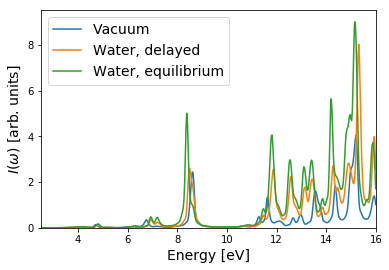

In [54]:
print('Analysis for uranyl')
Hartree2eV = scipy.constants.value('Hartree energy in eV')

print('Computing TD signal and spectrum in vacuum')
root_name = 'UO2_2+_magnus-delta'
npz_file_name = reader(data_dir, root_name)
raw_signal = np.load(npz_file_name)
signal = Signal(raw_signal)
vacuum, poles = signal.compute_spectrum(eas_prefactor)

print('Computing TD signal and spectrum in water, delayed propagation')
root_name = 'UO2_2+_magnus-delta_pcm'
npz_file_name = reader(data_dir, root_name)
raw_signal = np.load(npz_file_name)
signal = Signal(raw_signal)
delayed, poles = signal.compute_spectrum(eas_prefactor)

print('Computing TD signal and spectrum in water, equilibrium propagation')
root_name = 'UO2_2+_magnus-delta_eq+pcm'
npz_file_name = reader(data_dir, root_name)
raw_signal = np.load(npz_file_name)
signal = Signal(raw_signal)
equilibrium, poles = signal.compute_spectrum(eas_prefactor)

# We are now ready to plot the spectrum. 
# The energy scale of the spectrum data structure is in Hartree, but we can easily convert it to electronvolt.
vacuum_eV = (vacuum[0] * Hartree2eV, vacuum[1])
# Plot only below 16 eV
vacuum_eV = filter_spectrum_data(vacuum_eV, 16.0)

delayed_eV = (delayed[0] * Hartree2eV, delayed[1])
# Plot only below 16 eV
delayed_eV = filter_spectrum_data(delayed_eV, 16.0)

equilibrium_eV = (equilibrium[0] * Hartree2eV, equilibrium[1])
# Plot only below 16 eV
equilibrium_eV = filter_spectrum_data(equilibrium_eV, 16.0)

# x is the excitation energy axis (eV). It is the same for all data sets
# y is the imaginary part of the intensity (arbitrary units)
# We interpolate with a cubic B-spline with smoothing factor 0.01
x, y_vacuum = cubic_spline_smoothing(vacuum_eV[0], np.imag(vacuum_eV[1]), s=0.01)
_, y_delayed = cubic_spline_smoothing(delayed_eV[0], np.imag(delayed_eV[1]), s=0.01)
_, y_equilibrium = cubic_spline_smoothing(equilibrium_eV[0], np.imag(equilibrium_eV[1]), s=0.01)
plt.xlim(2.5, x.max())
plt.ylim(0.0, 
         max(np.amax(y_vacuum), np.amax(y_delayed), np.amax(y_equilibrium)) + 0.5)

plt.plot(x, y_vacuum, label='Vacuum')
plt.plot(x, y_delayed, label='Water, delayed')
plt.plot(x, y_equilibrium, label='Water, equilibrium')
plt.xlabel('Energy [eV]', fontsize=14)
plt.ylabel('$I(\omega)$ [arb. units]', fontsize=14)
plt.legend(fontsize=14)
fname = str(pathlib.Path('uranyl-RT-spectrum.svg').resolve())
plt.savefig(fname, format='svg', dpi=300, bbox_inches='tight')
plt.show()